In [ ]:
# PyTorch
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import Module, Conv2d, Linear, Dropout2d, CrossEntropyLoss
import torch.nn.functional as F
from torch import Tensor
from torch import cat
from torchvision.models import mobilenet_v3_large

# Visualization
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc

: 

In [3]:
# Folder direction
train_data = datasets.ImageFolder('C:/Users/grupo_gepar/Documents/lucho/Osteo/Processing/Train', transform=transforms.Compose([transforms.ToTensor()]))
test_data = datasets.ImageFolder('C:/Users/grupo_gepar/Documents/lucho/Osteo/Processing/Test', transform=transforms.Compose([transforms.ToTensor()]))

In [4]:
#e train and test Tensor size
print(f"Data tensor Dimension:",train_data[0][0].shape)

Data tensor Dimension: torch.Size([3, 224, 224])


In [5]:
#Convert to DataLoader
train_loader = DataLoader(train_data, shuffle=True, batch_size=1)
test_loader = DataLoader(test_data, shuffle=True, batch_size=1)

In [6]:
#Show the labels
print((train_loader.dataset.class_to_idx))

{'Normal': 0, 'Ostheo': 1}


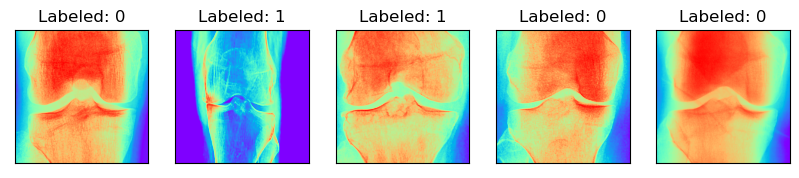

In [7]:
n_samples_show = 5

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 10))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap=plt.cm.rainbow)
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title(f"Labeled: {targets[0].item()}")

    n_samples_show -= 1

In [ ]:
# Definir una clase para la red neuronal
class Net(Module):
    def __init__(self):
        super(Net, self).__init__()
        # Cargar el modelo MobileNetV3 pre-entrenado
        self.mobilenet = mobilenet_v3_large(pretrained=True)
        # Congelar los parámetros del modelo pre-entrenado
        for param in self.mobilenet.parameters():
            param.requires_grad = False
        # Definir capas adicionales para adaptar el modelo a la tarea específica
        self.fc1 = Linear(1000, 512)  # Ajustar el número de neuronas en la capa lineal
        self.fc2 = Linear(512, 2)  # Salida para dos clases

    def forward(self, x):
        # Pasa la entrada a través del modelo MobileNetV3
        x = self.mobilenet(x)
        # Pasa la salida a través de las capas adicionales
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # Aplicar la función softmax para obtener probabilidades
        x = F.softmax(x, dim=1)
        return x


: 

In [ ]:
if __name__ == '__main__':  
    # Check if GPU is available
    if torch.cuda.is_available():
        # Get the current GPU device index
        model = Net().to('cuda')
        current_gpu = torch.cuda.current_device()
        print(f"Currently using GPU {current_gpu}")
    else:
        model = Net()
        print("GPU is not available. Using CPU.")

: 

In [ ]:

print(f"Device: {next(model.parameters()).device}")

: 

In [ ]:
#dummy_tensor = next(iter(train_loader))[0].to('cuda')
dummy_tensor = next(iter(train_loader))[0]
output = model(dummy_tensor)
params = dict(list(model.named_parameters()))

# Concatenamos los tensores utilizando torch.cat en lugar de cat
concatenated_output = torch.cat((output, 1 - output), -1)

#make_dot(concatenated_output, params=params).render("rnn_torchviz", format="png")
# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = CrossEntropyLoss()

# Comienza el entrenamiento
epochs = 1  # Número de épocas
loss_list = []
model.train()  # Modelo en modo de entrenamiento

for epoch in range(epochs):
    correct = 0
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Se inicializa el gradiente
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()  # Backward pass
        optimizer.step()  # Optimización de pesos
        total_loss.append(loss.item())  # Cálculo de la función de pérdida
        train_pred = output.argmax(dim=1, keepdim=True)
        correct += train_pred.eq(target.view_as(train_pred)).sum().item()
    loss_list.append(sum(total_loss) / len(total_loss))
    accuracy = 100 * correct / len(train_loader)  # Cálculo de precisión
    print(f"Training [{100.0 * (epoch + 1) / epochs:.0f}%]\tLoss: {loss_list[-1]:.4f}\tAccuracy: {accuracy:.2f}%")

: 

In [ ]:
# Evaluar el modelo en el conjunto de prueba
model.eval()
correct = 0

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_pred = output.argmax(dim=1, keepdim=True)
        correct += test_pred.eq(target.view_as(test_pred)).sum().item()

accuracy = 100 * correct / len(test_loader.dataset)
print(f"Accuracy on test set: {accuracy:.2f}%")

: 

In [ ]:
# Graficar la pérdida durante el entrenamiento
plt.plot(loss_list)
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el entrenamiento')
plt.show()

: 

In [ ]:
# Guardar los pesos del modelo
torch.save(model.state_dict(), '/home/luistorrest/Documents/Projects/Research/OSTHEO/Epoca_mobilinetv3.pth')

: 

In [ ]:
# Evaluar el modelo en el conjunto de prueba
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_pred = output.argmax(dim=1, keepdim=True)
        all_preds.append(test_pred.item())
        all_targets.append(target.item())

# Calcular y mostrar métricas adicionales
accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds)
recall = recall_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Mostrar el informe de clasificación
print("\nClassification Report:")
print(classification_report(all_targets, all_preds))

: 

In [ ]:
# Evaluar el modelo en el conjunto de prueba
model.eval()
all_probs = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        probs = output[:, 1].numpy()  # Probabilidades de pertenecer a la clase 1
        all_probs.append(probs)

# Concatenar las probabilidades de todas las muestras
all_probs = np.concatenate(all_probs)

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(all_targets, all_probs)
roc_auc = auc(fpr, tpr)

# Mostrar la curva ROC y el AUC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

: 

: 